In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as exp
import seaborn as sns

## Исследуем и подготавливаем данные

In [98]:
data = pd.read_csv('fake_job_postings.csv', index_col='job_id')

In [12]:
data.shape

(17880, 17)

In [11]:
data.head(3)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [19]:
data.isna().sum() # Количество NaN по столбцам

title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [21]:
data.nunique()

title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

### Категориальные данные

In [99]:
categorical_col = [
    'department', 'salary_range', 'employment_type', 'required_experience', 'required_education', 'industry', 'function'
]

for cat in categorical_col:
    val = set(data[cat].values)
    category_mapping = dict(zip(val, range(len(val))))
    
    data[cat] = data[cat].fillna(np.nan).apply(lambda x: category_mapping[x])

### Текстовые колонки

Добавим признаки количества слов и длины всего описания для текстовых данных

In [100]:
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']

for col in text_columns:
    data['len_' + col] = data[col].fillna('').apply(lambda x: len(x))
    data['cnt_' + col] = data[col].fillna('').apply(lambda x: len(x.split()))

data.drop(columns=text_columns, inplace=True) # Возможно применить какой-то препроцессинг к данным

### Location

In [103]:
#data.drop(columns=['location'], inplace=True) # Нужно приделать категории штатов, стран, городов

In [ ]:
# Посмотреть корреляцию новых признаков

### Pearson Correlation

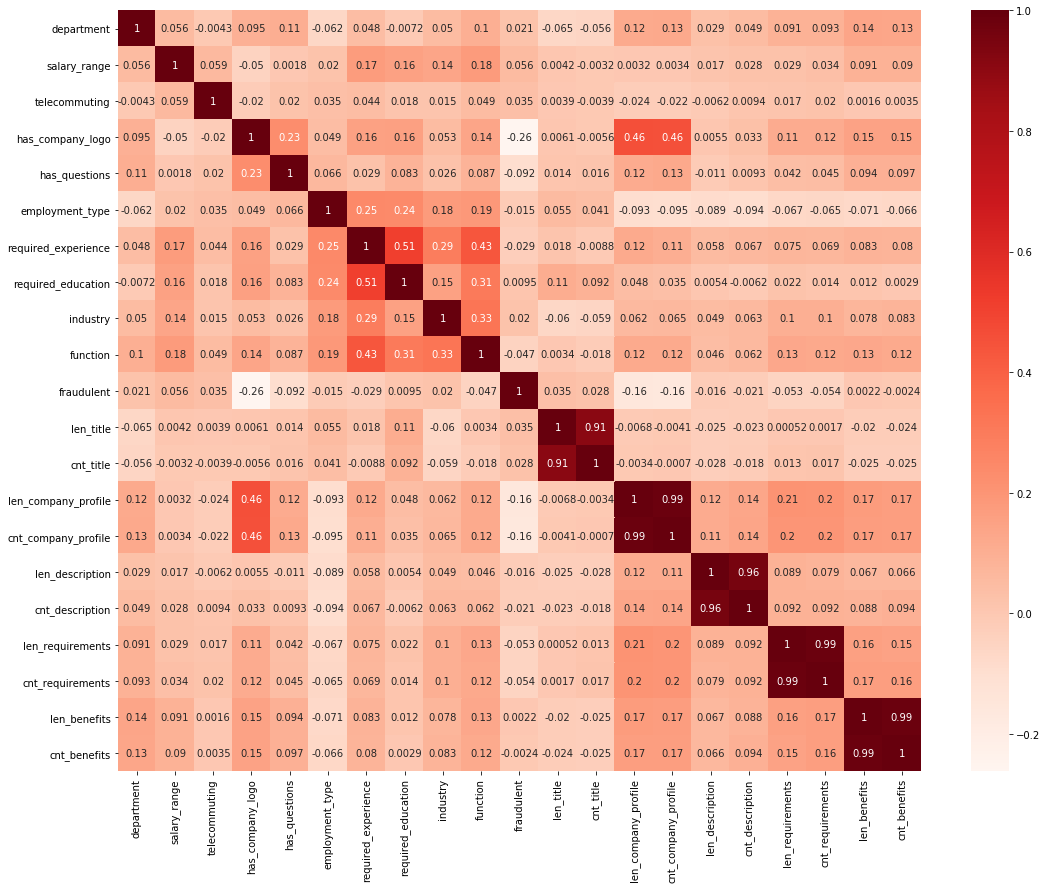

In [114]:
plt.figure(figsize=(18,14))

cor = data.corr()

sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

plt.show()

#### Видим, что целевая переменная сильно не коррелирует ни с одним признаком

## Модель предсказания

In [142]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

### Выборка имеет очень несбалансированные классы, поэтому постараемся решить эту проблему

In [140]:
# add class weights
positive = data[data['fraudulent'] == 1].shape[0]
negative = data[data['fraudulent'] == 0].shape[0]

class_weights = {0: 1, 1: negative / positive}
class_weights.values(), data.shape[0] / (2 * negative), data.shape[0] / (2 * positive)

(dict_values([1, 19.64665127020785]), 0.5254496297167038, 10.323325635103926)

In [162]:
target = data['fraudulent']
features = data.drop(columns=['fraudulent'])
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0) # Разделяем выборку

In [174]:
tmp = x_test
tmp['ans'] = y_test

x_test = pd.concat([tmp, tmp[tmp.ans == 1].sample(5100, replace=True)])
y_test = tmp['ans']
x_test = tmp.drop(columns = ['ans'])

In [177]:
def calculate_metrics(pred, real):
    tp = (pred[real == 1] == 1).sum()
    fp = (pred[real == 0] == 1).sum()
    fn = (pred[real == 1] == 0).sum()

    accuracy = (pred == real).sum() / real.shape[0]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1

In [179]:
def train_and_evaluate_model(classifier):
    model = classifier
    
    model.fit(x_train, y_train)
    predicted = model.predict(x_test)
    
    print(print("Accuracy {} \nPrecision {}\nRecall {}\nF1 {}".format(*calculate_metrics(predicted, y_test))))
    
    return predicted, model

#### LogisticRegression (baseline)

In [181]:
predicted, _ = train_and_evaluate_model(LogisticRegression(class_weight='balanced'))

Accuracy 0.742737003058104 
Precision 0.7144717564707798
Recall 0.823915900131406
F1 0.7653007846556235
None


C:\Users\zemer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



#### Gradient boosting algorithms

In [201]:
# Catboost
catboost_pred, catboost_model = train_and_evaluate_model(
    CatBoostClassifier(
        num_trees = 100,
        verbose=0, 
        class_weights=list(class_weights.values())
    )
)

Accuracy 0.9139908256880734 
Precision 0.9597092419522326
Recall 0.8674676177961329
F1 0.9112601064878723
None


In [202]:
catboost_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 6,
 'border_count': 254,
 'class_weights': [1, 19.646652221679688],
 'classes_count': 0,
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.25035199522972107,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 10,
 'bootstrap_type': 'MVS',
 'max_leaves': 64}

In [200]:
# XGBoost
predicted, _ = train_and_evaluate_model(
    XGBClassifier(
        num_trees=100,
        class_weights=list(class_weights.values())
    )
)

Accuracy 0.8583715596330275 
Precision 0.9948519948519948
Recall 0.7255490895438333
F1 0.8391228831958315
None


Со стандартными параметрами уже есть точность в 91% на CatBoostClassifier. Попытаемся улучшить качество модели

### Первый способ. Сделаем поиск гиперпараметров с помощью GridSearch

In [ ]:
params = {'num_trees': [75, 100, 150], 'depth': [4, 6], 'verbose': [0]}

grid_search = GridSearchCV(CatBoostClassifier(), params)
grid_search.fit(x_train, y_train)

In [211]:
print("Accuracy {} \nPrecision {}\nRecall {}\nF1 {}".format(
    *calculate_metrics(grid_search.best_estimator_.predict(x_test), y_test))
     )

Accuracy 0.8315175840978594 
Precision 0.9947251526929484
Recall 0.6726112258306739
F1 0.8025534774330831


### Второй способ. Добавим новые признаки

Так как мы почти не использовали текстовое описание, то попробуем извлечь признаки из них. Для этого используем TF-IDF.